# Analyse BlueSeis BSPF Events

With pressure sensor parascientific and new sensor 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig

In [3]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("IRIS")

    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")


    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        
    return waveform, inventory

## Configurations

In [4]:
config = {}

In [5]:
# config['datapath_femto'] = "/home/andbro/Downloads/tmp/IXBL/HJ*.D/*"
config['datapath'] = "/home/andbro/Downloads/tmp/BSPF/HJ*.D/*"

config['inventory'] = obs.read_inventory("/home/andbro/Documents/LMU_Docs/USA/BlueSeis/PY.BSPF.XX.xml")

config['seed_blueseis'] = "PY.BSPF..HJ*"
config['seed_seismometer'] = "II.PFO.10.BH*" ## Trillium next to BlueSeis on Pier

FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/Documents/LMU_Docs/USA/BlueSeis/PY.BSPF.XX.xml'

## Event Info

In [7]:
## Peru / Ecuador 
# config['tbeg'] = obs.UTCDateTime("2022-10-05 10:26")
# config['tend'] = obs.UTCDateTime("2022-10-05 10:40")

## Near PFO  - !! with XX location code
# config['tbeg'] = obs.UTCDateTime("2022-10-05 15:39:32")
# config['tend'] = obs.UTCDateTime("2022-10-05 15:39:45")

## ---- North Pacific Ocean -> No
# config['title'] = "North Pacific Ocean | 2022-10-25 18:40 UTC | M5.8"
# config['tbeg'] = obs.UTCDateTime("2022-11-02 04:53:00")
# config['tend'] = obs.UTCDateTime("2022-11-02 05:53:00")
# config['fmin'], config['fmax'] = 0.1, 0.5

## ---- Culf of California M5.1 -> No
# config['title'] = "Central California | 2022-10-25 18:40 UTC | M5.1"
# config['tbeg'] = obs.UTCDateTime("2022-10-25 18:40:00")
# config['tend'] = obs.UTCDateTime("2022-10-25 19:00:00")
# config['fmin'], config['fmax'] = 0.1, 0.5

## ---- Local M3.8-> No
# config['title'] = "Local | 2022-10-11 06:19 UTC | M3.8"
# config['tbeg'] = obs.UTCDateTime("2022-10-11 06:19:00")
# config['tend'] = obs.UTCDateTime("2022-10-11 06:30:00")
# config['fmin'], config['fmax'] = 0.5, 15.0


## Gulf of California M6.2 -> somewhat
config['title'] = "Gullf of California | 2022-11-04 10:02 UTC | M6.2"
config['tbeg'] = obs.UTCDateTime("2022-11-04 10:02")
config['tend'] = obs.UTCDateTime("2022-11-04 10:15")
config['fmin'], config['fmax'] = 0.025, 0.2

## Load Data

In [8]:
# ## read data stream using obspy routine
# st0 = obs.read(config['datapath'], 
#                format="MSEED",
#                startime=config['tbeg']-60,
#                endtime=config['tend']+60)


# ## merge traces that might be split due to data gaps or overlaps
# st0.merge(fill_value="interpolate")

# ## cut to event
# st0.trim(config['tbeg'], config['tend'])

# ## remove mean
# st0.detrend("demean")

# ## apply taper
# st0.taper(0.1)

# ## renove sensitivity
# st0.remove_sensitivity(config['inventory'])

# ## show all traces in data stream
# print(st0)

# st0.plot(equal_scale=False);

In [9]:
py_bspf0, py_bspf_inv = __request_data("PY.BSPF..HJ*", config['tbeg'], config['tend'])

Failed to load waveforms!


UnboundLocalError: local variable 'waveform' referenced before assignment

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-04T10:02:00.001300Z - 2022-11-04T10:15:00.001300Z | 200.0 Hz, 156001 samples
PY.BSPF..HJN | 2022-11-04T10:02:00.001300Z - 2022-11-04T10:15:00.001300Z | 200.0 Hz, 156001 samples
PY.BSPF..HJZ | 2022-11-04T10:02:00.001300Z - 2022-11-04T10:15:00.001300Z | 200.0 Hz, 156001 samples


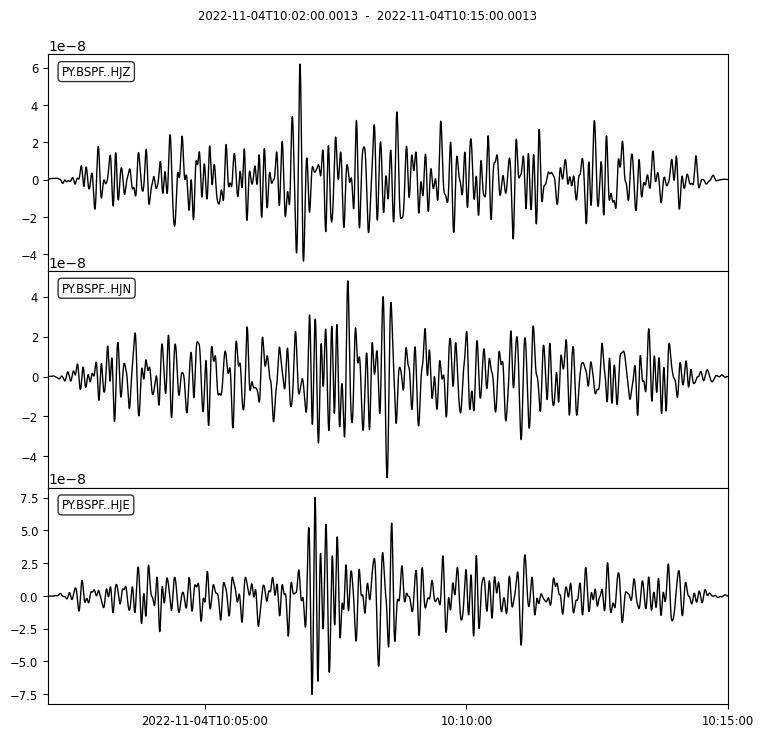

In [64]:
py_bspf = py_bspf0.copy()

## merge traces that might be split due to data gaps or overlaps
py_bspf.merge(fill_value="interpolate")

## cut to event
py_bspf.trim(config['tbeg'], config['tend'])

## renove sensitivity
py_bspf.remove_sensitivity(py_bspf_inv)

## remove mean
py_bspf.detrend("demean")

## apply taper
py_bspf.taper(0.1)

## bandpass filter
py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

## adjust channel names
for tr in py_bspf:
    if tr.stats.channel[-1] == "1":
        tr.stats.channel = str(tr.stats.channel).replace("1","E")
    if tr.stats.channel[-1] == "2":
        tr.stats.channel = str(tr.stats.channel).replace("2","N")        
    if tr.stats.channel[-1] == "3":
        tr.stats.channel = str(tr.stats.channel).replace("3","Z")

## show all traces in data stream
print(py_bspf)

py_bspf.plot(equal_scale=False);

## Compare with Seismometer

In [65]:
ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])

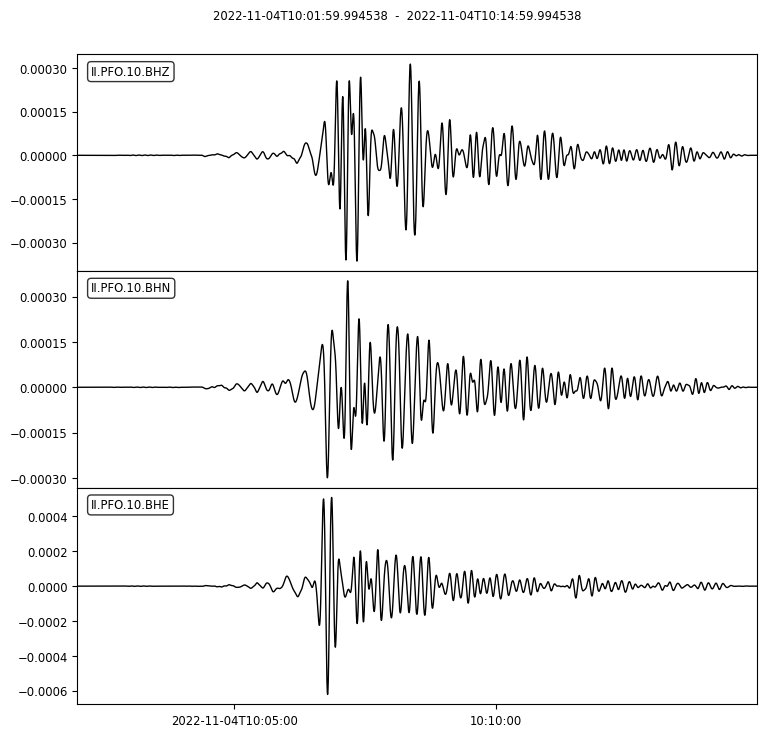

In [66]:
ii_pfo = ii_pfo0.copy()

pre_filt = [0.005, 0.01, 19, 20]

## cut properly
ii_pfo.trim(config['tbeg'], config['tend'])

## demean
ii_pfo.detrend("demean")

## remove response
ii_pfo.remove_response(inventory=ii_pfo_inv, 
                       pre_filt=pre_filt, 
                       output="VEL",
                       water_level=60, 
                       plot=False)

## taper 
ii_pfo.taper(0.1)

## bandpass
ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

## adjust channel names
for tr in ii_pfo:
    if tr.stats.channel[-1] == "1":
        tr.stats.channel = str(tr.stats.channel).replace("1","N")
    if tr.stats.channel[-1] == "2":
        tr.stats.channel = str(tr.stats.channel).replace("2","E")
        

ii_pfo.plot(equal_scale=False);

### Join Data

In [67]:
st_new = py_bspf.copy()
st_new += ii_pfo

### Plotting

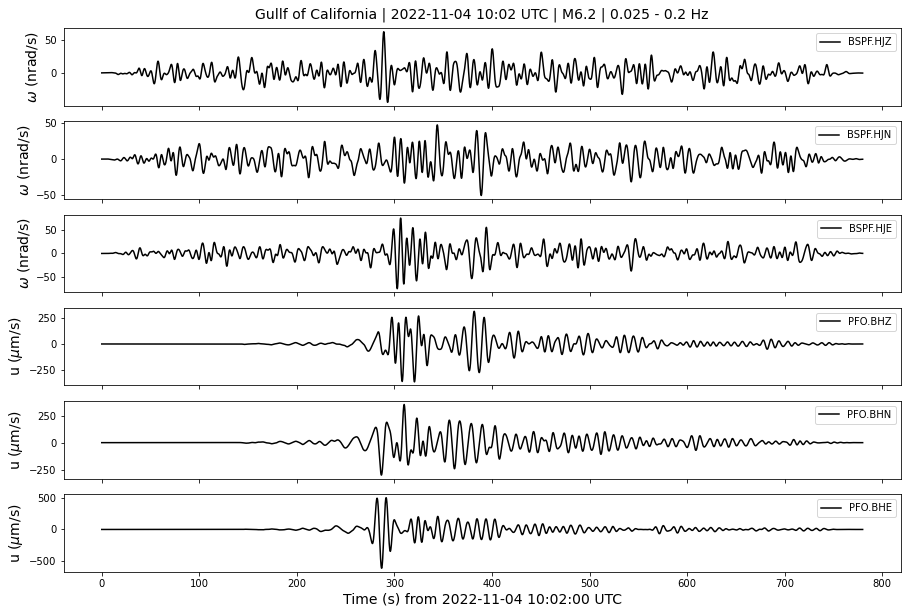

In [71]:
def __makeplot(config, st):

    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times(), tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times(), tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time (s) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    return fig

fig = __makeplot(config, st_new)

In [ ]:
# __savefig(fig, outpath="/home/andbro/Downloads/tmp/BSPF/", outname="BSPF_event_1", mode="png", dpi=300)

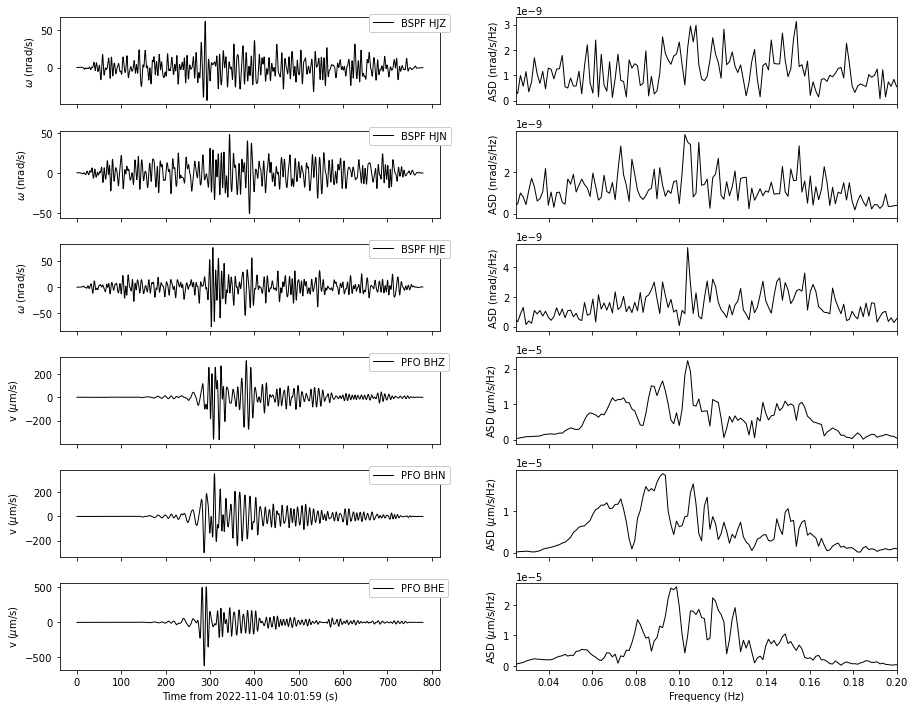

In [69]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    NN = len(st)
    rot_scaling = 1e9
    trans_scaling = 1e6
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        spec, ff, ph = __fft(tr.data, tr.stats.delta, window=None, normalize=None)

        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = "$\omega$", "nrad/s"
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", "$\mu$m/s"
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})')    
        axes[i,1].set_ylabel(f'ASD ({unit}/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)" )     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)" )     

    return fig

fig = __makeplotStreamSpectra2(st_new, config, fscale="linlin");

In [ ]:
# __savefig(fig, outpath="/home/andbro/Downloads/tmp/BSPF/", outname="BSPF_ASD_event_1", mode="png", dpi=300)

## Load ADR 

In [40]:
datapath_adr = "/home/andbro/Downloads/tmp/BSPF/adr/*.mseed"

## read data stream using obspy routine
st_adr = obs.read( datapath_adr, 
                   format="MSEED",
                   startime=config['tbeg']-60,
                   endtime=config['tend']+60,
                 )

# ## merge traces that might be split due to data gaps or overlaps
st_adr.merge(fill_value="interpolate")

# ## cut to event
st_adr.trim(config['tbeg'], config['tend'])

# ## remove mean
st_adr.detrend("demean")

# ## apply taper
st_adr.taper(0.1)

# ## renove sensitivity
# st_adr.remove_sensitivity(config['inventory'])

# ## show all traces in data stream
print(st_adr)

st_adr.plot(equal_scale=False);

0 Trace(s) in Stream:



IndexError: Empty stream object

In [ ]:
datapath_adr = "/home/andbro/Downloads/tmp/BSPF/adr/*.mseed"

## read data stream using obspy routine
st_adr = obs.read( datapath_adr, 
                   format="MSEED",
                   startime=config['tbeg']-60,
                   endtime=config['tend']+60,
                 )


# ## merge traces that might be split due to data gaps or overlaps
st_adr.merge(fill_value="interpolate")

# ## cut to event
st_adr.trim(config['tbeg'], config['tend'])

# ## remove mean
st_adr.detrend("demean")

# ## apply taper
st_adr.taper(0.1)

# ## renove sensitivity
# st_adr.remove_sensitivity(config['inventory'])

# ## show all traces in data stream
print(st_adr)

st_adr.plot(equal_scale=False);

## Combine Streams

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


3 Trace(s) in Stream:
II.PFO.10.BH1 | 2022-10-25T18:39:59.994538Z - 2022-10-25T18:59:59.994538Z | 40.0 Hz, 48001 samples
II.PFO.10.BH2 | 2022-10-25T18:39:59.994538Z - 2022-10-25T18:59:59.994538Z | 40.0 Hz, 48001 samples
II.PFO.10.BHZ | 2022-10-25T18:39:59.994538Z - 2022-10-25T18:59:59.994538Z | 40.0 Hz, 48001 samples


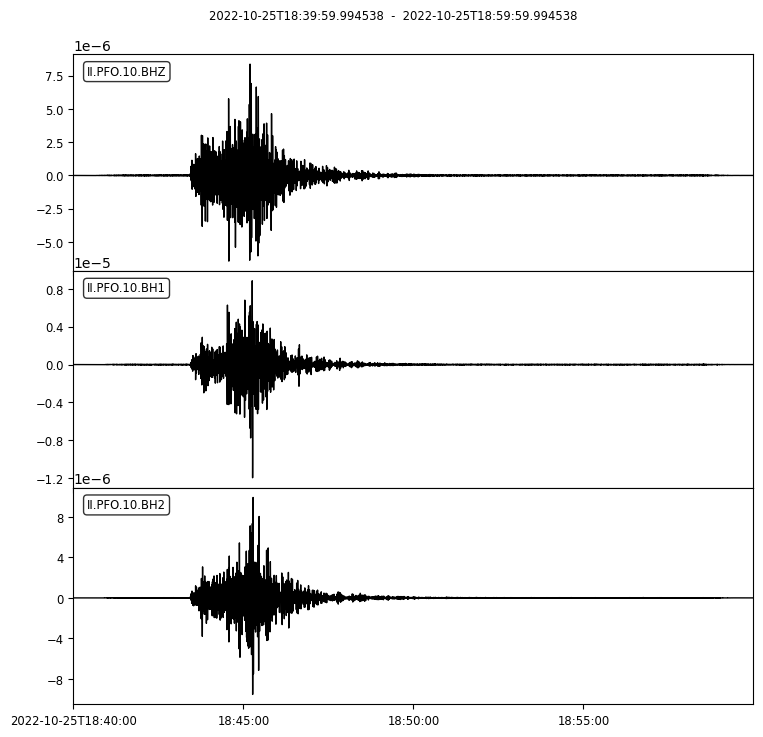

In [93]:
st3 = st0.copy()

## add traces
st3 += ii_pfo
st3 += st_adr

st3.sort()

## filter
config['fmin'], config['fmax'] = 0.5, 20.0
st3.detrend("demean")
st3.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

## resample all to 40 Hz
st3.resample(40)

print(st3)
st3.plot(equal_scale=False);

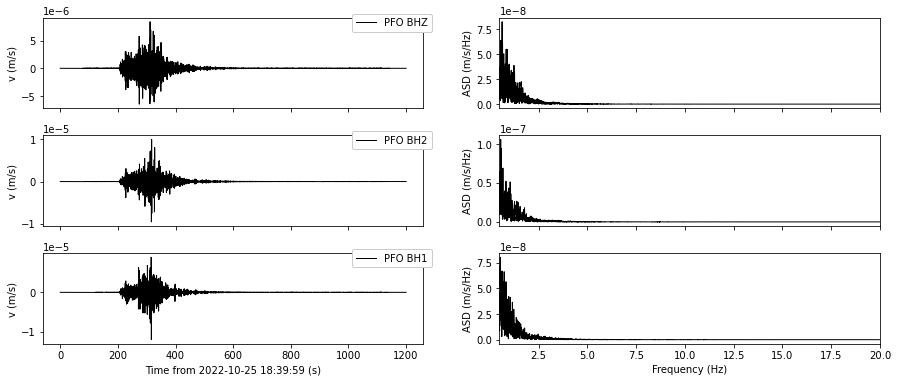

In [95]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    NN = len(st)
    
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        spec, ff, ph = __fft(tr.data, tr.stats.delta, window=None, normalize=None)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = "$\Omega$", "rad/s"
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", "m/s"
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})')    
        axes[i,1].set_ylabel(f'ASD ({unit}/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)" )     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)" )     

    return fig

fig = __makeplotStreamSpectra2(st3, config, fscale="linlin");

In [ ]:
# __savefig(fig, outpath="/home/andbro/Downloads/tmp/BSPF/", outname="BSPF_event_1", mode="png", dpi=300)